In [67]:
import requests
import json
import overpy as opy
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from itertools import chain
import osm2geojson

## Different ways of using overpass query to construct polygond data

Here will be using an example, to see the capabilites of what we can do with OSM data. I selected some vineyards in France

In [2]:
#How to access the overpass query interperter

api = opy.Overpass()
overpass_query = api.query("""
[bbox:44.453388800301774,-0.56304931640625,46.240651955001695,2.3345947265625]
[timeout:25]
;
(
  node["landuse"="vineyard"];
  way["landuse"="vineyard"];
  relation["landuse"="vineyard"];
);
out center;
""")




Get just the point of the shapefiles

In [45]:
overpass_api = "http://overpass-api.de/api/interpreter"
the_query  = """
[out:json]
[bbox:44.453388800301774,-0.56304931640625,46.240651955001695,2.3345947265625]
[timeout:25]
;
(
  node["landuse"="vineyard"];
  way["landuse"="vineyard"];
  relation["landuse"="vineyard"];
);
out center;
"""

In [49]:
response = requests.get(overpass_api, params = {'data' : the_query})

In [65]:
result = osm2geojson.json2geojson(response.json())

In [91]:
from geojson import dump

with open(r'C:\Users\brunolopez\mldata\osm\vineyard_france.geojson', 'w') as f:
   dump(result, f)

In [92]:
import_json= gpd.read_file(r'C:\Users\brunolopez\mldata\osm\vineyard_france.geojson') #reads in the geojson file

In [93]:
geometry_for = import_json['geometry'] #gets the geometry of all Areas, Multipolyogn and Points
id_num_for = import_json['id'] #returns the id tht was used
len(geometry_for)

10903

In [122]:
geometry_for.to_file(r'C:\Users\brunolopez\mldata\osm\vineyards.shp')

<AxesSubplot: >

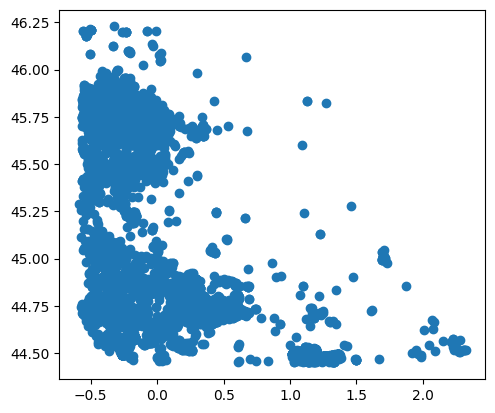

In [115]:
geometry_for.plot()

I'll also be adding a function that generates a query statement, based on a user defined bounding box

In [2]:
def overpass_query_constructor_bbox(min_lat, min_lon, max_lat, max_lon, key = 'landuse', value = 'vineyard', timeout = 25):

    '''
    Constructs a query using overpy. First a bounding box using a min_lat min_lon, max_lat and max long. and then you
    can select the catefory

        Parameters:
            min_lat (float): Minimum Latitude (WGS-84)
            min_lon (float): Minimum Longitude (WGS-84)
            max_lat (float): Maximum Latitude (WGS-84)
            max_lon (float): Maximum Longitude (WGS-84)
            key (str): Key for OSM category (ex: https://wiki.openstreetmap.org/wiki/Key:landuse)
            value (str): Value for OSM category
            timeout (int): Timeout for query (seconds), if your query is timeout might be a lot of data.


        Returns:
            query_creator (str): Query to run using the overpy api


    '''

    #constructs a query based on a key, value and you can set timeout also
    query_creator = """
    [bbox: {0}, {1}, {2}, {3}]
    [timeout:{4}]
    ;
    (
        node[{5} = {6}];
        way[{5} = {6}];
        relation[{5} = {6}];
    );
    out center;

    """.format(str(min_lat), str(min_lon), str(max_lat), str(max_lon), str(timeout), key, value)

    return query_creator
    

It might be useful to see what kind of values exist for specific keys as well. For that we will scrape OSM's wikipedia and
pull out the table from the values column

In [43]:
def view_values(key, base_url = "http://wiki.openstreetmap.org/wiki/Key:"):
    '''
    Scrape OSM data given a specific key. Returns a table containg, the key, value, element, description, and rendering

        Parameters:
            key (str): A key from OSM. Here is
            an example of the key landuse https://wiki.openstreetmap.org/wiki/Key:landuse


        Returns:
            final_table (str): Returns a table containing all of the different valuies, elements and descriptions.


    '''


    full_url = base_url + key
    #send a requests to the created URL
    response = requests.get(full_url)

    #instantiate our beautiful soup object
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_response = soup.find('table', {'class':'wikitable'})

    #put into a table pandas table
    read_html = pd.read_html(str(soup_response))
    final_frame = pd.DataFrame(read_html[0])

    #filter so that the only key is the key that was passed in

    return final_frame


Now let's see the keys from the landuse value.

In [45]:
landuse_table = view_values('landuse')
landuse_table.head(3)

,Key,Value,Element,Description,Rendering,Photo,Unnamed: 6_level_0
,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land
0,landuse,commercial,NaN,Predominantly commercial businesses and their ...,NaN,NaN,NaN
1,landuse,construction,NaN,A site which is under active development and c...,NaN,NaN,NaN
2,landuse,education,NaN,An area predominately used for educational pur...,NaN,NaN,NaN


Okay now let's fix the naming of the columns and get rid of the photo and rending and the last column. You can see all of the values that fall under this key. You can change the function above to see different keys.

In [46]:
landuse_table_drop = landuse_table.iloc[:, 1:4]
landuse_table_drop.head()

,Value,Element,Description
,Common landuse key values - developed land,Common landuse key values - developed land,Common landuse key values - developed land
0,commercial,NaN,Predominantly commercial businesses and their ...
1,construction,NaN,A site which is under active development and c...
2,education,NaN,An area predominately used for educational pur...
3,industrial,NaN,Predominantly industrial landuses such as work...
4,residential,NaN,Land where people reside; predominantly reside...


Example Box
44.453388800301774,-0.56304931640625,46.240651955001695,2.3345947265625

In [51]:
the_query = overpass_query_constructor_bbox(44.453388800301774, -0.56304931640625, 46.240651955001695, 2.3345947265625, timeout = 30)
print(the_query)


    [bbox: 44.453388800301774, -0.56304931640625, 46.240651955001695, 2.3345947265625]
    [timeout:30]
    ;
    (
        node[landuse = vineyard];
        way[landuse = vineyard];
        relation[landuse = vineyard];
    );
    out center;

    


Let's now save all of the output from OSM into coordinates. For the ways and relations, we
are taking the center polygon.

In [4]:
node_coords = [(float(node.lon), float(node.lat)) 
           for node in overpass_query.nodes]

In [5]:
node_coords = [(float(node.lon), float(node.lat)) 
           for node in overpass_query.nodes]
way_coords = [(float(way.center_lon), float(way.center_lat)) 
           for way in overpass_query.ways]
relation_coords = [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in overpass_query.relations]

Let's see what information we can get out of this using the overpy package

In [6]:
def metadata_info(result_overpass):

    coords = []

    print("Number of ways: ", len(overpass_query.ways))
    print("Number of nodes: ", len(overpass_query.nodes))
    print("Number of relations: ", len(overpass_query.relations))



metadata_info(overpass_query)

Number of ways:  10436
Number of nodes:  2
Number of relations:  460


Lwt's see how we can extract all of the nodes from the nodes, ways and relations

In [7]:
overpass_query.nodes[0]

<overpy.Node id=1590507069 lat=45.4965397 lon=0.0298435>

In [8]:
overpass_query.ways[0].id

25308659

In [9]:
print(overpass_query.ways[0].get_nodes(resolve_missing = True))

[<overpy.Node id=275673915 lat=45.8371811 lon=1.1282429>, <overpy.Node id=275673935 lat=45.8368817 lon=1.1325448>, <overpy.Node id=275673936 lat=45.8357616 lon=1.1319743>, <overpy.Node id=275673964 lat=45.8352961 lon=1.1306867>, <overpy.Node id=2156225512 lat=45.8365380 lon=1.1279466>, <overpy.Node id=275673915 lat=45.8371811 lon=1.1282429>]


In [36]:
overpass_query.ways[0].get_nodes(resolve_missing = True)[0]

<overpy.Node id=275673915 lat=45.8371811 lon=1.1282429>

Let's see the same thing except with some of the relations

In [5]:
overpass_query.relations

[<overpy.Relation id=274627>,
 <overpy.Relation id=274637>,
 <overpy.Relation id=274643>,
 <overpy.Relation id=274648>,
 <overpy.Relation id=275672>,
 <overpy.Relation id=275676>,
 <overpy.Relation id=275697>,
 <overpy.Relation id=275703>,
 <overpy.Relation id=276652>,
 <overpy.Relation id=276666>,
 <overpy.Relation id=276667>,
 <overpy.Relation id=277163>,
 <overpy.Relation id=277864>,
 <overpy.Relation id=277879>,
 <overpy.Relation id=277882>,
 <overpy.Relation id=277883>,
 <overpy.Relation id=278460>,
 <overpy.Relation id=279365>,
 <overpy.Relation id=279368>,
 <overpy.Relation id=279369>,
 <overpy.Relation id=279371>,
 <overpy.Relation id=279397>,
 <overpy.Relation id=280136>,
 <overpy.Relation id=280165>,
 <overpy.Relation id=280194>,
 <overpy.Relation id=295581>,
 <overpy.Relation id=296398>,
 <overpy.Relation id=297198>,
 <overpy.Relation id=298920>,
 <overpy.Relation id=299105>,
 <overpy.Relation id=2240253>,
 <overpy.Relation id=2240254>,
 <overpy.Relation id=2593815>,
 <overp

In [8]:
overpass_query.relations[0]

<overpy.Relation id=274627>

In [10]:
print(overpass_query.relations[0].members)

[<overpy.RelationWay ref=326355422 role=outer>, <overpy.RelationWay ref=326360676 role=outer>, <overpy.RelationWay ref=326328889 role=outer>, <overpy.RelationWay ref=326382332 role=outer>, <overpy.RelationWay ref=326328887 role=outer>, <overpy.RelationWay ref=326240440 role=outer>, <overpy.RelationWay ref=41647159 role=outer>, <overpy.RelationWay ref=326356418 role=outer>, <overpy.RelationWay ref=327061500 role=outer>, <overpy.RelationWay ref=326355627 role=outer>, <overpy.RelationWay ref=326336181 role=outer>, <overpy.RelationWay ref=326329682 role=outer>, <overpy.RelationWay ref=326360675 role=outer>, <overpy.RelationWay ref=41647162 role=inner>, <overpy.RelationWay ref=41647163 role=inner>, <overpy.RelationWay ref=41647164 role=inner>]


In [11]:
print(overpass_query.relations[1].members[0])

<overpy.RelationWay ref=41647395 role=outer>


In [4]:
print(overpass_query.relations[1].members[1].resolve(resolve_missing = True))

<overpy.Way id=41647398 nodes=[511284551, 511284553, 511284556, 511284559, 511284561, 511284566, 511284568, 511284571, 511284574, 511284579, 511284582, 511284585, 511284606, 511284551]>


In [13]:
print(overpass_query.relations[1].members[1].resolve(resolve_missing = True).get_nodes(resolve_missing = True))

[<overpy.Node id=511284551 lat=45.2957196 lon=-0.5742611>, <overpy.Node id=511284553 lat=45.2963902 lon=-0.5740606>, <overpy.Node id=511284556 lat=45.2966443 lon=-0.5739994>, <overpy.Node id=511284559 lat=45.2970968 lon=-0.5754785>, <overpy.Node id=511284561 lat=45.2989639 lon=-0.5761570>, <overpy.Node id=511284566 lat=45.2997947 lon=-0.5804391>, <overpy.Node id=511284568 lat=45.2993153 lon=-0.5838307>, <overpy.Node id=511284571 lat=45.2985870 lon=-0.5835819>, <overpy.Node id=511284574 lat=45.2962429 lon=-0.5839311>, <overpy.Node id=511284579 lat=45.2957817 lon=-0.5761114>, <overpy.Node id=511284582 lat=45.2951633 lon=-0.5762590>, <overpy.Node id=511284585 lat=45.2948259 lon=-0.5746477>, <overpy.Node id=511284606 lat=45.2957218 lon=-0.5742980>, <overpy.Node id=511284551 lat=45.2957196 lon=-0.5742611>]


Using all of this above, we can iterate through all of the nodes and get the coords. We are also able to do this for the ways and relations. From the coordinates for this, we can iterate through all of the ways to get the nodes. From the nodes we can reconstruct the geomery and then finally
can creata shapefile for each of the shapes.



In [11]:
class OSMGeometries:

    def __init__(self, overpass_query):
        self.overpass_query = overpass_query
        

    def nodes_dataframe(self):
        #get a list of tuple for the coordinates in WGS 84  
        
        lon_node = []
        lat_node = []
        id_node = []

        for node in self.overpass_query.nodes:
            lon_node.append(float(node.lon))
            lat_node.append(float(node.lat))
            id_node.append(int(node.id))

        final_frame = pd.DataFrame({"lon": lon_node, "lat": lat_node, "node_id": id_node})

        return final_frame

    
    def ways_dataframe(self):

        lon_node = []
        lat_node = []
        id_node = []
        id_way = []

        #First for loop over the ways
        for way in self.overpass_query.ways:
            #create a list of all of the different ways 
            the_nodes = way.get_nodes(resolve_missing = True)
            way_id = way.id
            #second for loop loops over the nodes
            for node in the_nodes:
                lon_node.append(float(node.lon))
                lat_node.append(float(node.lat))
                id_node.append(int(node.id))
                id_way.append(way_id)

        final_frame = pd.DataFrame({"lon": lon_node, "lat": lat_node, "node_id": id_node, 'way_id': id_way})

        return final_frame

    def relation_dataframe(self):

        lon_node = []
        lat_node = []
        id_node = []
        id_way = []
        id_relation = []

        for relation in self.overpass_query.relations:
            
            relation_id = relation.id
            the_relation = relation.members
            for way in the_relation:

                the_way = way.resolve(resolve_missing = True)
                way_id = the_way.id
                for node in the_way:
                    #get the nodes and append. We can do the final constructing of polygons in a seperate class or function
                    the_node = node.get_nodes(resolve_missing = True)
                    lon_mode = lon_node.append(float(the_node.way))
                    lat_node.append(float(the_node.lat))
                    id_node.append(int(the_node.id))
                    id_way.append(way_id)
                    id_relation(the_relation)

        final_frame = pd.DataFrame({"lon": lon_node, "lat": lat_node, "node_id": id_node, 'way_id': id_way, "relation_id" : id_relation})

    

    

In [12]:
the_query = OSMGeometries(overpass_query)

In [13]:
node_test = the_query.nodes_dataframe()
node_test

,lon,lat,node_id
0,0.029843,45.496540,1590507069
1,-0.124944,44.801304,6647305399


In [14]:
way_test  = the_query.ways_dataframe()

In [128]:
way_test

,lon,lat,node_id,way_id
0,1.128243,45.837181,275673915,25308659
1,1.132545,45.836882,275673935,25308659
2,1.131974,45.835762,275673936,25308659
3,1.130687,45.835296,275673964,25308659
4,1.127947,45.836538,2156225512,25308659
...,...,...,...,...
165421,-0.576111,45.295782,511284579,41647398
165422,-0.576259,45.295163,511284582,41647398
165423,-0.574648,45.294826,511284585,41647398
165424,-0.574298,45.295722,511284606,41647398


In [129]:
way_test.to_csv(r'C:\Users\brunolopez\mldata\osm\vineyards_ways.csv')

Now let's create our geomtries from our using our nodes

In [142]:
way_test[way_test['way_id'] == way_test['way_id'].unique()[0]]

6

In [145]:
from shapely.geometry import Polygon, Point

def create_geometries(geometries_csv):

    geometry_list = []

    for i in geometries_csv['way_id'].unique():

        filter_frame = geometries_csv[geometries_csv['way_id'] == i]

        if len(filter_frame > 1):
            lat_point_list = filter_frame['lat']
            lon_point_list = filter_frame['lon']

            polygon_geo = Polygon(zip(lon_point_list, lat_point_list))
            geometry_list.append(polygon_geo)

        elif len == 1:
            lat_point_list = filter_frame['lat']
            lon_point_list = filter_frame['lon']
            point_geo = Point(lon_point_list, lat_point_list)
            geometry_list.append(point_geo)

        else:
            continue
            

    return geometry_list
        

In [146]:
the_geos = create_geometries(way_test)

In [158]:
the_polygons = gpd.GeoDataFrame(geometry = the_geos, crs = 'EPSG:4326')
the_polygons

,geometry
0,"POLYGON ((1.12824 45.83718, 1.13254 45.83688, ..."
1,"POLYGON ((-0.55790 44.72095, -0.55942 44.72068..."
2,"POLYGON ((-0.56513 44.75442, -0.56486 44.75418..."
3,"POLYGON ((-0.56027 44.74781, -0.56006 44.74691..."
4,"POLYGON ((-0.56002 44.73513, -0.56013 44.73508..."
...,...
10438,"POLYGON ((1.14315 44.51790, 1.14334 44.51798, ..."
10439,"POLYGON ((1.14206 44.51744, 1.14216 44.51738, ..."
10440,"POLYGON ((1.14144 44.51692, 1.14172 44.51689, ..."
10441,"POLYGON ((-0.57609 45.30636, -0.57648 45.30721..."


Export the shapefile 

In [161]:
the_polygons.to_file(r'C:\Users\brunolopez\mldata\osm\vineyards_polygons.shp')